In [36]:
# Includes libraries
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

## Utils Functions

In [37]:
def find_weeks(dataframe):
    """
    Find the successive rows which are in the same week

    Parameters
    ----------
    dataframe : pandas.DataFrame
        The dataframe containing the data

    Returns
    -------
    pandas.DataFrame
        The dataframe containing the data with the week number
    """
    keys = ["Date"] + dataframe.columns.tolist()
    week = []
    
    # Create a dataframe to store the weekly data
    df_cycle = pd.DataFrame()

    # Iterate through the dataframe
    for i_date, i_values in dataframe.iterrows():
        # Check if current date is monday
        is_monday = i_date.weekday() == 0
        
        # Check if current date is friday and the data_week contains previous 4 days
        is_friday = len(week) == 4 and i_date.weekday() == 4

        # Check if the date is next day of the last date in data_week
        is_next_day = len(week) != 0 and week[-1][0] + datetime.timedelta(days=1) == i_date

        # Fill the week list with i_values
        if is_monday or is_friday or is_next_day:
            week = [] if is_monday else week
            week += [[i_date] + i_values.values.tolist()]

        # If the week contains 5 days, add it to the dataframe
        if len(week) == 5:
            df_week = pd.DataFrame(week, columns=keys)
            df_cycle = pd.concat([df_cycle, df_week], axis=0)
            week = []

    return df_cycle


def group_weeks(dataframe):
    """
    Concatenate the rows that are in the same week

    Parameters
    ----------
    dataframe : pandas.DataFrame
        The dataframe containing the data

    Returns
    -------
    pandas.DataFrame
        The dataframe containing the data with the week number
    """
    df_cyclic = dataframe.drop(columns=["Company", "Date"])
    df_weeks = pd.DataFrame()

    # Create column names containing the week number
    columns = []

    for j in range(5):
        for i in range(df_cyclic.shape[1]):
            columns += [df_cyclic.columns[i] + "_" + str(j)]

    # Iterate every 5 rows to create a dataframe for each week
    for i in range(0, len(df_cyclic), 5):
        # Create a series containing the week data
        week = np.append(df_cyclic[i:i+5].values, dataframe["Company"].iloc[i]).reshape(1, -1)
        week = np.insert(week, 0, dataframe["Date"].iloc[i].date(), axis=1)
        week = pd.DataFrame(week)

        # Add the week series to the weeks dataframe
        df_weeks = pd.concat([df_weeks, week], axis=0)

    df_weeks.columns = ["Date"] + columns + ["Company"]

    return df_weeks.reset_index(drop=True)

## I. Data Preprocessing

In [38]:
# Set the path to the data
path = "data/"

# Write data into a dataframe
dataframe = pd.DataFrame()

for file in os.listdir(path):
    df_read = pd.read_csv(path + file, sep = ",")
    df_read["Company"] = file.split("(")[0]
    df_read["Date"] = pd.to_datetime(df_read["Date"])
    df_read.set_index("Date", inplace=True)
    df_read = find_weeks(df_read)
    df_read = group_weeks(df_read)

    dataframe = pd.concat([dataframe, df_read], axis=0)

# Set the date as the index
dataframe["Date"] = pd.to_datetime(dataframe["Date"])
dataframe.set_index("Date", inplace=True)

# Convert the columns to numeric except the 'Company' column
numeric_columns = dataframe.columns[dataframe.columns != "Company"]
dataframe[numeric_columns] = dataframe[numeric_columns].astype(float)

# Save the dataframe as a csv file
# dataframe.to_csv("weekly_data.csv")

dataframe.head()

,Open_0,High_0,Low_0,Close_0,Adj Close_0,Volume_0,Open_1,High_1,Low_1,Close_1,...,Close_3,Adj Close_3,Volume_3,Open_4,High_4,Low_4,Close_4,Adj Close_4,Volume_4,Company
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-07,9.276582,10.405363,9.229810,9.853446,9.853446,3727496.0,9.834737,10.380418,9.747428,10.015591,...,10.074836,10.074836,856590.0,10.046773,10.121609,9.909573,10.093545,10.093545,580788.0,ZG
2013-01-14,10.215154,10.361709,10.043655,10.302463,10.302463,873266.0,10.289991,10.477081,10.212036,10.352354,...,10.071718,10.071718,805919.0,10.043655,10.439663,10.006236,10.355472,10.355472,867494.0,ZG
2013-01-28,11.088244,11.764889,10.994699,11.615217,11.615217,1932538.0,11.506080,11.506080,10.760836,10.826317,...,11.799189,11.799189,1123733.0,11.842844,11.842844,11.328344,11.537262,11.537262,1014374.0,ZG
2013-02-04,11.175553,11.506080,11.069535,11.481135,11.481135,634665.0,11.527908,11.849080,11.465544,11.827253,...,11.446835,11.446835,648135.0,11.490490,11.499844,11.166199,11.200499,11.200499,1337960.0,ZG
2013-02-11,11.259744,11.406299,11.163081,11.318990,11.318990,1192042.0,11.381353,11.640162,11.200499,11.272217,...,13.189897,13.189897,14261529.0,13.252261,14.150296,13.037106,14.009978,14.009978,5422396.0,ZG


In [39]:
# Load the dataframes already saved
dataframe = pd.read_csv("weekly_data.csv")

In [40]:
print(f"Total number of missing values: {dataframe.isnull().sum().sum()}")
dataframe.drop(["Company"], axis=1).describe()

Total number of missing values: 0


,Open_0,High_0,Low_0,Close_0,Adj Close_0,Volume_0,Open_1,High_1,Low_1,Close_1,...,Low_3,Close_3,Adj Close_3,Volume_3,Open_4,High_4,Low_4,Close_4,Adj Close_4,Volume_4
count,12576.000000,12576.000000,12576.000000,12576.000000,12576.000000,1.257600e+04,12576.000000,12576.000000,12576.000000,12576.000000,...,12576.000000,12576.000000,12576.000000,1.257600e+04,12576.000000,12576.000000,12576.000000,12576.000000,12576.000000,1.257600e+04
mean,78.055401,79.059313,77.050397,78.115126,74.813691,3.173252e+07,78.235989,79.183661,77.219097,78.203377,...,77.202958,78.216668,74.921602,3.285176e+07,78.253644,79.144698,77.190071,78.179601,74.885862,3.438584e+07
std,75.587629,76.675148,74.488578,75.710433,75.987190,4.856106e+07,75.815509,76.824855,74.727377,75.794895,...,74.674221,75.711573,75.989412,4.828235e+07,75.734394,76.635671,74.578126,75.610566,75.886549,5.108344e+07
min,1.670000,1.700000,1.610000,1.620000,1.620000,1.436000e+05,1.620000,1.690000,1.620000,1.660000,...,1.660000,1.700000,1.700000,1.749000e+05,1.680000,1.750000,1.650000,1.670000,1.670000,1.341000e+05
25%,28.345625,28.641996,27.967681,28.287501,25.007929,6.118600e+06,28.306545,28.663370,27.990702,28.326427,...,28.035520,28.360001,25.078379,6.430675e+06,28.375872,28.700001,28.064085,28.382764,25.148379,6.529200e+06
50%,52.860001,53.563001,52.180000,52.904998,49.470890,1.681095e+07,52.979999,53.681249,52.207174,53.003750,...,52.270000,53.070000,49.698305,1.748610e+07,53.014999,53.664999,52.392876,53.013001,49.631620,1.810615e+07
75%,101.884998,103.000000,100.560001,101.612501,97.653346,3.699230e+07,102.000000,103.099998,100.802502,101.929998,...,101.042502,102.232502,98.006184,3.876410e+07,102.121876,103.270998,101.029999,102.130003,97.904793,4.079450e+07
max,689.059998,689.969971,676.539978,681.169983,681.169983,7.855176e+08,683.109985,688.359985,676.900024,687.400024,...,679.739990,682.020020,682.020020,7.599116e+08,692.349976,694.159973,675.000000,690.309998,690.309998,7.640976e+08


In [41]:
# Label encode the company column
enc = OneHotEncoder(handle_unknown="error")
company_encoded = enc.fit_transform(dataframe[["Company"]]).toarray()
df_company_encoded = pd.DataFrame(company_encoded, columns=enc.get_feature_names_out())
dataframe_enc = pd.concat([dataframe, df_company_encoded], axis=1)
dataframe_enc.drop(["Company"], axis=1, inplace=True)

In [42]:
dataframe_enc.head()

,Date,Open_0,High_0,Low_0,Close_0,Adj Close_0,Volume_0,Open_1,High_1,Low_1,...,Company_NVDA,Company_PFE,Company_PYPL,Company_T,Company_TSLA,Company_TTD,Company_WMT,Company_XOM,Company_YELP,Company_ZG
0,2013-01-07,13.266705,13.386636,12.938321,13.143918,11.812600,5607402.0,13.212450,13.375214,12.941176,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2013-01-14,12.412907,12.418618,12.238721,12.412907,11.155633,3008568.0,12.364363,12.412907,12.075957,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2013-01-28,11.553398,11.793261,11.507710,11.616219,10.439638,4930116.0,11.659052,11.687607,11.427756,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2013-02-04,11.747573,11.881782,11.681896,11.753284,10.562821,3747840.0,11.821816,12.247287,11.810394,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2013-02-11,12.541405,12.561393,12.361508,12.421473,11.163330,7001198.0,12.361508,12.378641,12.107367,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
# Select the features and the target
X = dataframe_enc.drop(["Date", "Open_4", "High_4", "Low_4", "Close_4", "Adj Close_4", "Volume_4"], axis=1)
y = dataframe_enc["Close_4"]

# Split the data into train, test and validation sets.
# Train set: 70%, Validation set: ~20%, Test set: ~10%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.3, shuffle=True)

(X_train.shape, y_train.shape), (X_val.shape, y_val.shape), (X_test.shape, y_test.shape)

(((8803, 54), (8803,)), ((2641, 54), (2641,)), ((1132, 54), (1132,)))

In [44]:
# Standardize the data
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)
X_test = ss.transform(X_test)

The number of principal components is: 54


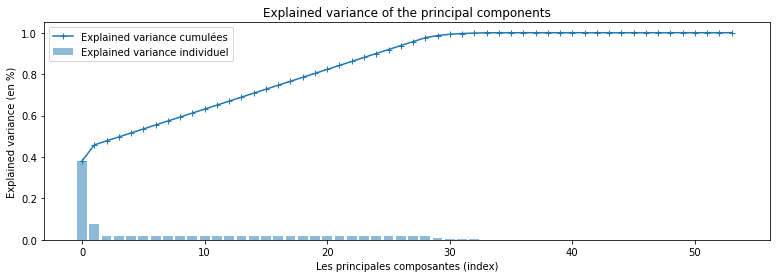

In [45]:
# Application of the PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
print(f"The number of principal components is: {pca.n_components_}")

# Visualization of the explained variance of the principal components
exp_var_pca = pca.explained_variance_ratio_

plt.figure(figsize=(13, 4))
plt.bar(range(len(exp_var_pca)), height=exp_var_pca, label="Explained variance individuel", alpha=.5)
plt.plot(np.cumsum(exp_var_pca), marker="+", label="Explained variance cumulées")
plt.xlabel("Les principales composantes (index)")
plt.ylabel("Explained variance (en %)")
plt.title("Explained variance of the principal components")
plt.legend()
plt.show()

After analysing the above graph, we can see that the best n_components is 29, because after that the explained variance is almost constant.

In [46]:
# Application of the PCA with 29 components
pca = PCA(n_components=29)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

## II. Data Visualization

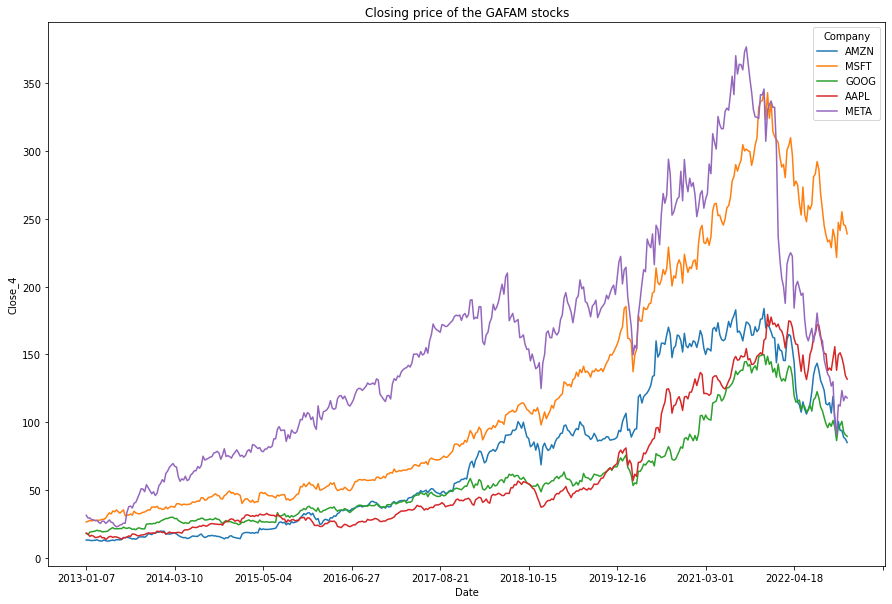

In [47]:
GAFAM = ["GOOG", "AMZN", "META", "AAPL", "MSFT"]
GAFAM = dataframe[dataframe["Company"].isin(GAFAM)]

# Plot the closing price of the GAFAM stocks
plt.figure(figsize=(15, 10))
ax = sns.lineplot(x="Date", y="Close_4", hue="Company", data=GAFAM)
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.title("Closing price of the GAFAM stocks")
plt.show()

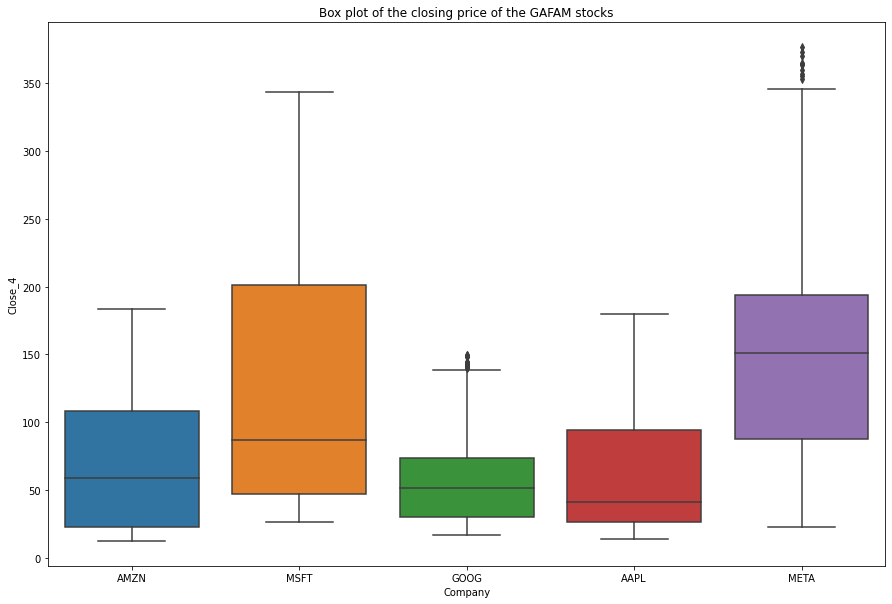

In [48]:
# Plot the box plot
plt.subplots(figsize=(15, 10))
sns.boxplot(x="Company", y="Close_4", data=GAFAM)
plt.title("Box plot of the closing price of the GAFAM stocks")
plt.show()

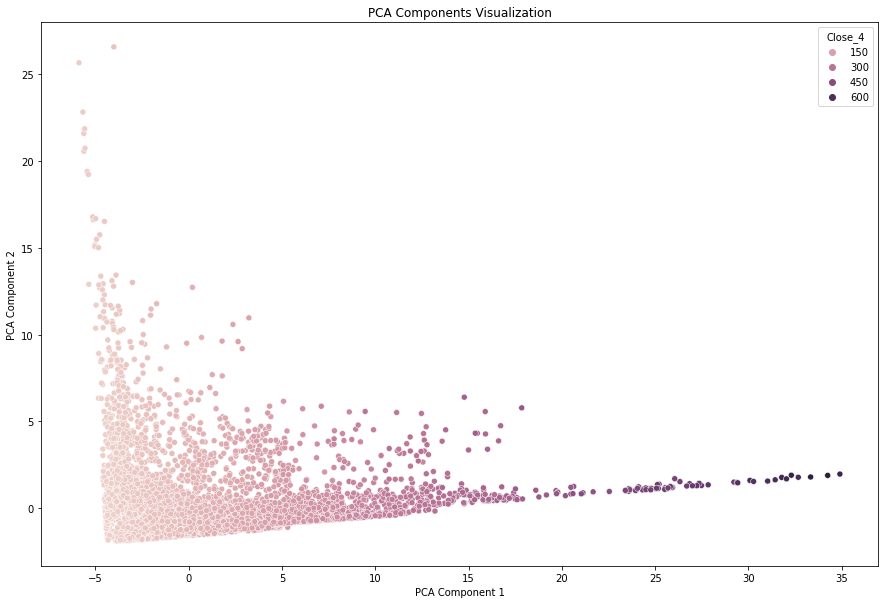

In [49]:
# PCA Components Visualization
plt.figure(figsize=(15, 10))
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train)
plt.title("PCA Components Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

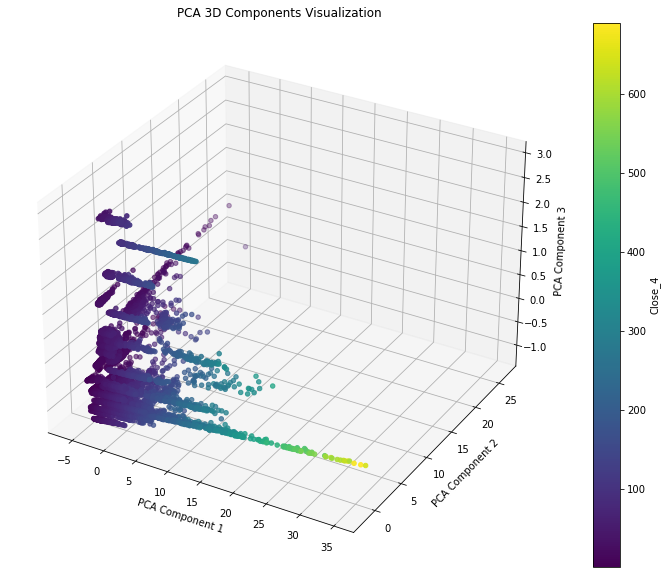

In [50]:
# PCA 3D Components Visualization
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], X_train_pca[:, 2], c=y_train, label="Close_4")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
cbar = plt.colorbar(scatter)
cbar.set_label("Close_4")
plt.title("PCA 3D Components Visualization")
plt.show()

In [51]:
# Define the model
lr = LinearRegression()

cr = lr.fit(X_train_pca, y_train)
print(f"MSE Train: {mean_squared_error(y_train, lr.predict(X_train_pca))}")
print(f"MSE Valid: {mean_squared_error(y_val, lr.predict(X_val_pca))}")

MSE Train: 17.809365125654733
MSE Valid: 15.989922586513249


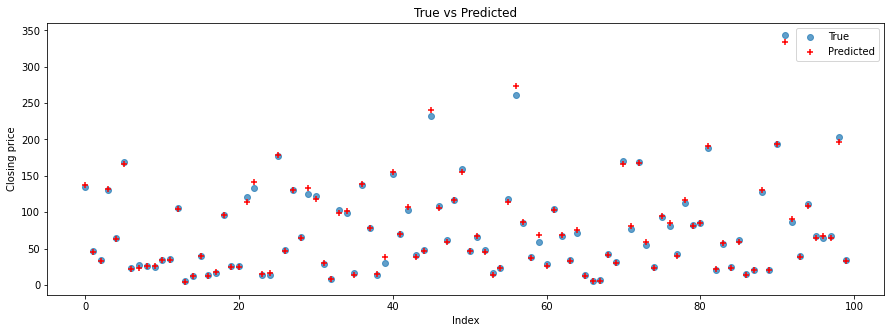

In [52]:
n = 100
y_pred = lr.predict(X_val_pca)
rand_ids = np.random.randint(0, len(X_val_pca), size=n)

plt.figure(figsize=(15, 5))
plt.scatter(x=range(n), y=y_val.values[rand_ids], label="True", alpha=.7)
plt.scatter(x=range(n), y=y_pred[rand_ids], label="Predicted", alpha=1, marker="+", c="red")
plt.legend()
plt.title("True vs Predicted")
plt.xlabel("Index")
plt.ylabel("Closing price")
plt.show()

-----
-----

----

In [152]:
df_stats = pd.DataFrame()

col = []
volume = []

for i in range(5):
    col += [f"Low_{i}", f"Open_{i}", f"High_{i}", f"Close_{i}"]
    volume += [f"Volume_{i}"]
    

thursday = [f"Low_3", f"Open_3", f"High_3", f"Close_3", "Volume_3"]

df_stats["Mean"] = dataframe[col].mean(axis=1)
df_stats["Std"] = dataframe[col].std(axis=1)
df_stats["Median"] = dataframe[col].median(axis=1)
df_stats["Range"] = dataframe[col].max(axis=1) - dataframe[col].min(axis=1)
df_stats["Volume"] = dataframe[volume].mean(axis=1)
df_stats[thursday] = dataframe[thursday]
df_stats["Close"] = dataframe["Close_4"]

df_stats.head()

,Mean,Std,Median,Range,Volume,Low_3,Open_3,High_3,Close_3,Volume_3,Close
0,12.872501,0.386993,12.984009,1.170759,5230237.0,12.215877,13.029697,13.058252,12.327242,8888076.0,12.390063
1,12.151342,0.192196,12.178755,0.576813,4743669.2,11.910337,12.178755,12.178755,11.944603,5452964.0,11.910337
2,11.692319,0.144450,11.684752,0.542547,4460427.4,11.587664,11.613364,11.896059,11.778983,5420746.0,11.867504
3,12.172473,0.340312,12.175899,1.087950,8698267.6,12.347230,12.441462,12.769846,12.527127,11385702.0,12.484295
4,12.148344,0.234347,12.135922,0.793832,6783864.2,11.856082,12.110223,12.130211,11.870360,5948497.0,11.907481


In [153]:
# Select the features and the target
X = df_stats.drop(["Close"], axis=1)
y = df_stats["Close"]

# Split the data into train, test and validation sets.
# Train set: 70%, Validation set: ~20%, Test set: ~10%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.3, shuffle=True)

(X_train.shape, y_train.shape), (X_val.shape, y_val.shape), (X_test.shape, y_test.shape)

(((8803, 10), (8803,)), ((2641, 10), (2641,)), ((1132, 10), (1132,)))

In [154]:
## gride search cv
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 50, 100],
    'max_features': [2, 3],
    'n_estimators': [10, 100, 500]
}

rf = RandomForestRegressor()

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

grid_search.best_params_

best_grid = grid_search.best_estimator_

print(f"MSE Train: {mean_squared_error(y_train, best_grid.predict(X_train))}")
print(f"MSE Valid: {mean_squared_error(y_val, best_grid.predict(X_val))}")


print( best_grid)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/Users/thomassinapi/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


MSE Train: 0.845762389926036
MSE Valid: 7.67286296365439
RandomForestRegressor(max_depth=100, max_features=3)


In [121]:
print( best_grid)

RandomForestRegressor(max_depth=10, max_features=3, n_estimators=500)


In [139]:
## gride search cv
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'max_depth': [10, 50, 100],
    'max_features': [1,  3, 5, 7, 9],
    'n_estimators': [10, 100, 200],
    'min_impurity_decrease': [0.0, 0.1, 0.2,0.6],
    'max_leaf_nodes': [10, 50, 100],
    'min_samples_leaf': [1, 2, 5],
}

rf = RandomForestRegressor()

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

grid_search.best_params_

best_grid = grid_search.best_estimator_

print(f"MSE Train: {mean_squared_error(y_train, best_grid.predict(X_train))}")
print(f"MSE Valid: {mean_squared_error(y_val, best_grid.predict(X_val))}")


Fitting 5 folds for each of 1620 candidates, totalling 8100 fits
MSE Train: 3.620810914409934
MSE Valid: 5.716427430632701


In [140]:
print( best_grid)

RandomForestRegressor(max_depth=50, max_features=9, max_leaf_nodes=100,
                      n_estimators=200)


In [115]:

### random forest regressor

# rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0)
# rf.fit(X_train, y_train)

# print(f"MSE Train: {mean_squared_error(y_train, rf.predict(X_train))}")
# print(f"MSE Valid: {mean_squared_error(y_val, rf.predict(X_val))}")

train_errors = []
val_errors = []
for i in np.arange(1, 100, 10):
    reg = RandomForestRegressor(n_estimators=i)
    reg.fit(X_train, y_train)
    train_errors.append(mean_squared_error(y_train, reg.predict(X_train)))
    val_errors.append(mean_squared_error(y_val, reg.predict(X_val)))

    

    





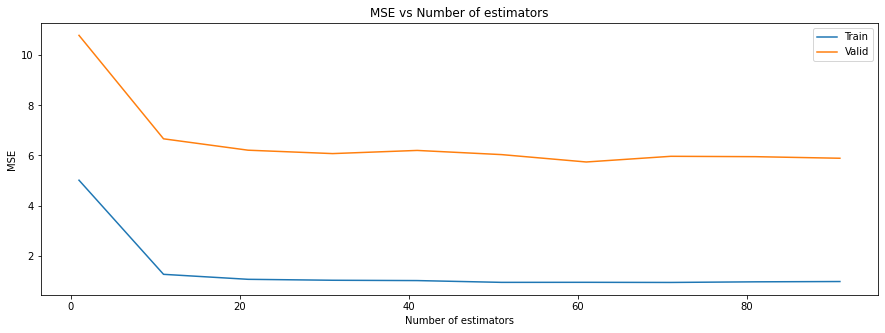

In [117]:
plt.figure(figsize=(15, 5))
plt.plot(np.arange(1, 100, 10), train_errors, label="Train")
plt.plot(np.arange(1, 100, 10), val_errors, label="Valid")
plt.legend()
plt.title("MSE vs Number of estimators")
plt.xlabel("Number of estimators")
plt.ylabel("MSE")
plt.show()

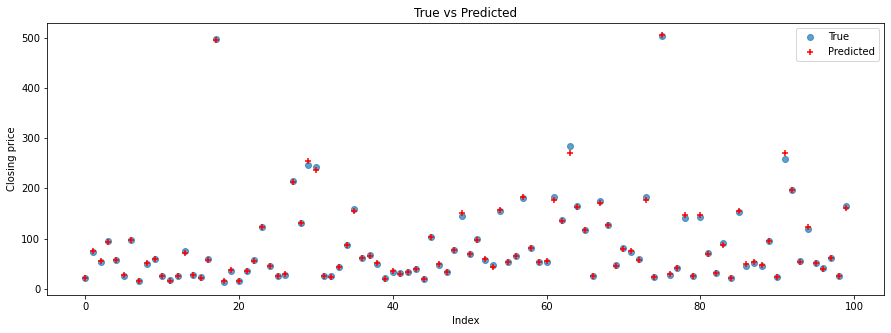

In [54]:
n = 100
y_pred = rf.predict(X_val_pca)
rand_ids = np.random.randint(0, len(X_val_pca), size=n)

plt.figure(figsize=(15, 5))
plt.scatter(x=range(n), y=y_val.values[rand_ids], label="True", alpha=.7)
plt.scatter(x=range(n), y=y_pred[rand_ids], label="Predicted", alpha=1, marker="+", c="red")
plt.legend()
plt.title("True vs Predicted")
plt.xlabel("Index")
plt.ylabel("Closing price")
plt.show()

----

In [155]:
### random forest regressor

rf = RandomForestRegressor(max_depth=50, max_features=9, max_leaf_nodes=100,
                      n_estimators=200)
rf.fit(X_train, y_train)

print(f"MSE Train: {mean_squared_error(y_train, rf.predict(X_train))}")
print(f"MSE Valid: {mean_squared_error(y_val, rf.predict(X_val))}")


# mean absolute error
from sklearn.metrics import mean_absolute_error

print(f"MAE Train: {mean_absolute_error(y_train, rf.predict(X_train))}")
print(f"MAE Valid: {mean_absolute_error(y_val, rf.predict(X_val))}")

MSE Train: 3.230342823993917
MSE Valid: 7.255665539652505
MAE Train: 1.0458135106900628
MAE Valid: 1.3519976329868817


In [156]:
# creer un dataframe avec les predictions et les vrais valeurs
df_pred = pd.DataFrame()
df_pred["y_val"] = y_val
df_pred["y_pred"] = rf.predict(X_val)
df_pred["error"] = df_pred["y_val"] - df_pred["y_pred"]
df_pred["error_abs"] = abs(df_pred["error"])
df_pred["error_squared"] = df_pred["error"]**2


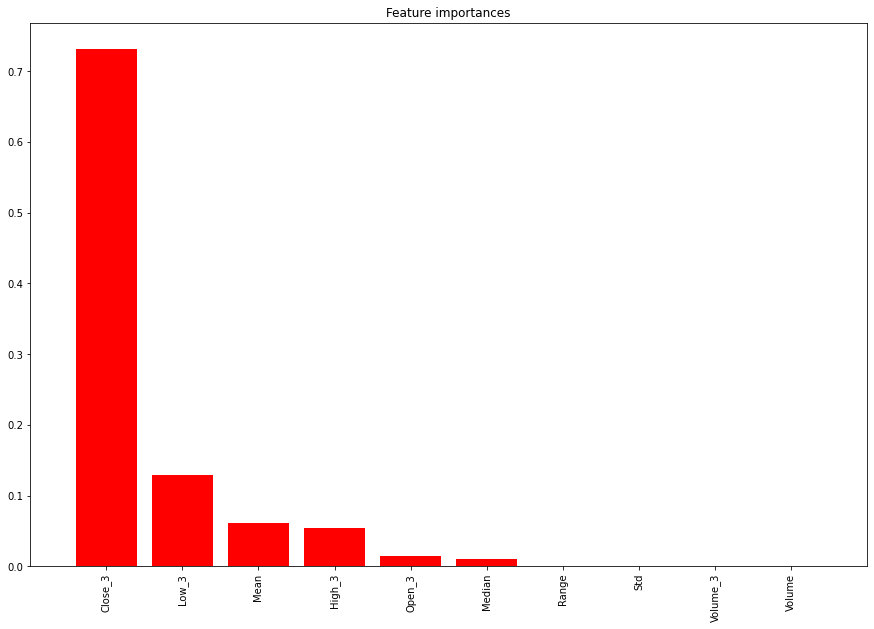

In [157]:
## importances des variables ordonnées

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(15, 10))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()





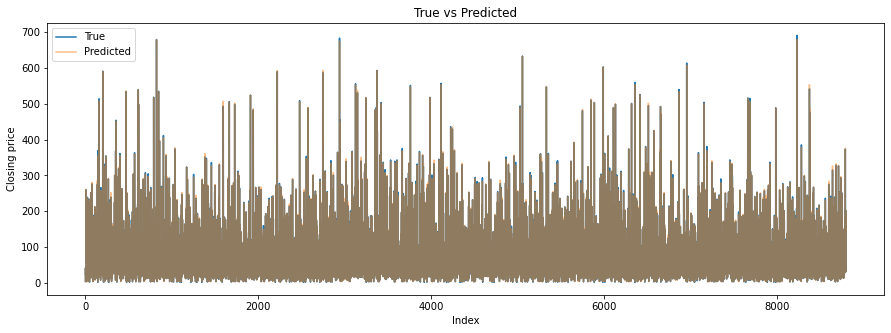

In [158]:
plt.figure(figsize=(15, 5))

plt.plot(range(len(y_train)), y_train, label="True")
plt.plot(range(len(y_train)), rf.predict(X_train), label="Predicted", alpha=.5)
plt.legend()
plt.title("True vs Predicted")
plt.xlabel("Index")
plt.ylabel("Closing price")
plt.show()

In [159]:
y_pred = rf.predict(X_val)

# Add predictions to the DataFrame
df_val = X_val.copy()
df_val["Actual_Close"] = y_val
df_val["Pred_Close"] = y_pred
df_val["Gain_Pred"] = y_pred - df_val["Close_3"]
df_val["Gain"] = df_val["Actual_Close"] - df_val["Close_3"]
df_val["Correct_Pred"] = df_val["Gain_Pred"] * df_val["Gain"] > 0

In [160]:
df_val.head(15)

,Mean,Std,Median,Range,Volume,Low_3,Open_3,High_3,Close_3,Volume_3,Actual_Close,Pred_Close,Gain_Pred,Gain,Correct_Pred
4964,321.685002,9.736761,321.275010,32.820007,51572260.0,310.250000,312.140015,324.779999,321.260010,47289000.0,306.929993,325.530296,4.270286,-14.330017,False
4259,81.292500,1.689901,81.790001,4.390000,17211960.0,82.419998,83.180000,83.320000,83.010002,11139900.0,79.209999,82.578145,-0.431857,-3.800003,True
4399,81.318499,0.638759,81.324997,2.459999,12427120.0,81.199997,81.199997,82.470001,81.849998,17448600.0,81.970001,81.787369,-0.062629,0.120003,False
1241,25.044475,1.507968,24.428750,5.243500,169332000.0,23.785000,24.583000,24.583000,24.108999,187488000.0,26.471001,24.172308,0.063309,2.362002,True
827,42.088000,0.778883,42.210001,2.180000,55973220.0,41.830002,42.410000,43.040001,43.029999,50260200.0,42.900002,43.285314,0.255315,-0.129997,False
860,32.313000,0.654611,32.220000,2.319998,51101520.0,31.490000,31.750000,31.990000,31.770000,49027600.0,31.700001,31.683415,-0.086585,-0.069999,True
2804,77.583500,1.329544,77.359997,5.680000,5411700.0,76.720001,77.720001,78.739998,78.699997,5904300.0,79.269997,78.598634,-0.101363,0.570000,False
556,17.564000,0.239833,17.595000,0.860001,66939840.0,17.620001,17.780001,17.850000,17.690001,51829700.0,17.650000,17.647666,-0.042335,-0.040001,True
11480,22.259567,0.954749,22.087334,3.070002,158200800.0,22.876667,23.021999,23.333332,23.139334,203025000.0,23.794001,23.140529,0.001195,0.654667,True
4316,85.563501,1.104932,85.565002,4.329994,13426200.0,85.660004,85.910004,87.989998,87.050003,14106100.0,85.669998,85.616060,-1.433943,-1.380005,True


In [161]:
accuracy = df_val["Correct_Pred"].sum() / len(df_val)
print(f"Accuracy: {accuracy}")

Accuracy: 0.5047330556607346
